In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import OrderedDict

In [3]:
from read_mnist import load_mnist

## 多层感知器
- 与单层感知器的区别是，在形式上至少为两层，在其他方面，多层感知器使用多使用几乎处处平滑的激活函数，例如Sigmod、ReLu函数等，而单层感知器使用阶跃函数作为激活函数  

### 非线性激活函数 
- 非线性激活函数给予了多层感知器“加深层数”的意义
- 处处平滑的激活函数能够支持“通过梯度下降优化“

In [3]:
def sigmod(x):
    return 1 / (1 + np.exp(-x))
def relu(x):
    return np.maximum(x, 0)
def h(x):
    return (x > 0).astype(np.int)

### 前向传播的Numpy实现 

In [4]:
class forward_3net(object):
    def __init__(self):
        self.network = {}
        self.network['W1'] = np.array([[1,2,3], [4.5, 3.4, 7]])
        self.network['b1'] = np.array([1,2,3])
        self.network['W2'] = np.array([[1,2], [4.5, 3.4], [2,4]])
        self.network['b2'] = np.array([1,2])
        self.network['W3'] = np.array([[1,2], [4.5, 3.4]])
        self.network['b3'] = np.array([1,2])
    def forward(self, x):
        A1 = np.dot(x, self.network['W1'])+self.network['b1']
        Z1 = sigmod(A1)
        A2 = np.dot(Z1, self.network['W2'])+self.network['b2']
        Z2 = sigmod(A2)
        A3 = np.dot(Z2, self.network['W3'])+self.network['b3']
        Z3 = sigmod(A3)
        return self.identiy_layer(Z3)
    def identiy_layer(self, x):
        return x

In [5]:
f_net = forward_3net()
x = np.array([1,-9])
f_net.forward(x)

array([ 0.99664735,  0.99843269])

### softmax函数，常用于输出层分类处理 
- 将输出层的数据映射为概率，常结合经过One-Hot编码的标签数据与交叉熵函数使用

In [6]:
def softmax(x):
    exp_x = np.exp(x)
    return  exp_x / np.sum(exp_x)

In [7]:
a = np.array([[1,2,3],[4,5,6]])
print softmax(a)
print sigmod(a)

[[ 0.00426978  0.01160646  0.03154963]
 [ 0.08576079  0.23312201  0.63369132]]
[[ 0.73105858  0.88079708  0.95257413]
 [ 0.98201379  0.99330715  0.99752738]]


In [8]:
def batch_softmax(x):
    if x.ndim == 1:
        x = x.reshape(1, x.shape[0])
    exp_x = np.exp(x)
    sum_x = np.sum(exp_x, axis=1)
    return exp_x / sum_x.reshape(-1, 1)

In [9]:
batch_softmax(a)

array([[ 0.09003057,  0.24472847,  0.66524096],
       [ 0.09003057,  0.24472847,  0.66524096]])

### 批处理 
- 为了提高训练速度，常常采用批处理的方式一次加载多个训练数据，因为计算机的并行计算在矩阵计算方面可以发挥优势

## 神经网络（多层感知器）的学习过程 
- 为了形式化神经网络的学习，引入损失函数等概念，形容推理能力的强弱、预测结果的好坏程度

### 损失函数
损失函数用来评估误差大小程度
- 均方误差
- 交叉熵误差

In [11]:
def mean_square_error(x1, x2):
    return np.sum(np.square(x1 - x2))/2
def cross_entropy_error(t, y):
    return -np.sum(y*np.log(t))

In [12]:
x1 = np.array([1,2,3])
x2 = np.array([1,5,8])
mean_square_error(x1, x2)

17

In [13]:
t = np.array([0.4,0.4,0.2])
y = np.array([1,0,0])
cross_entropy_error(t, y)

0.916290731874155

### mini_batch版本的损失函数
- 即每次选择一批数据作为学习的数据，然后尽可能的减小这批数据的训练误差或损失函数值

In [14]:
# t 表示预测值， y表示实际值
def batch_cross_entropy_error(t, y):
    if t.ndim == 1: # t 与 y 是一维数组的情况
        t = t.reshape(1, t.shape[0])
        y = y.reshape(1, y.shape[0])
    return -np.sum(y*np.log(t)) / t.shape[0]

In [15]:
t = np.array([[0.4,0.4,0.2],[0.4,0.4,0.2]])
y = np.array([[1,0,0],[0,0,1]])
batch_cross_entropy_error(t, y)

1.2628643221541276

## 导数、偏导数、梯度
- 训练多层感知器的数学基础

### 数值微分求近似导数
- 前向差分、后向差分、中心差分

In [18]:
def f(x):
    return x[0]**2 + x[1]**2
# 求函数f(x)在x=x_0处的近似导数
def numerical_diff(f, x_0):
    h = 1e-4
    return (f(x_0+h) - f(x_0-h)) / (2*h)
# 求函数f(x)在x=x_0处的近似偏导数，其中x是一个一维数组
def numerical_diff(f, x):
    grad = np.zeros_like(x)
    h = 1e-4
    for i in range(x.shape[0]):
        x[i] += h
        pre = f(x)
        
        x[i] -= 2*h
        last = f(x)
        
        grad[i] = (pre - last)/(2*h)
        x[i] +=h
    return grad

In [19]:
numerical_diff(f, np.array([3.0, 4.0]))

array([ 6.,  8.])

In [20]:
numerical_diff(f, np.array([0.0, 2.0]))

array([ 0.,  4.])

### 梯度法求最小值（局部）
- 函数某点梯度所指的方向即是该函数在该点增长最快的方向，梯度法求极值即是一种启发式算法，沿着梯度方向前进或后退来最快增大或者减小函数值

In [21]:
def gradient_descent(f, init_x, alpha=0.01, step_num=100):
    for i in range(step_num):
        grad = numerical_diff(f, init_x) # 使用数值微分求得近似导数
        init_x -= alpha*grad
    return init_x,f(init_x)

In [22]:
init_x = np.array([3.0, 4.0])
res_x,res = gradient_descent(f, init_x, alpha=0.1)

In [23]:
print res_x
print res

[  6.11110793e-10   8.14814391e-10]
1.0373788922e-18


###  两层神经网络
- 使用梯度下降法减小误差
- 通过数值微分计算梯度

In [24]:
class two_layer_network(object):
    def __init__(self):
        self.paras = {}
        self.paras['W1'] = np.random.randn(784,50)
        self.paras['b1'] = np.random.randn(50)
        self.paras['W2'] = np.random.randn(50,10)
        self.paras['b2'] = np.random.randn(10)
    def forward(self, x):
        A1 = np.dot(x, self.paras['W1']) + self.paras['b1']
        Z1 = sigmod(A1)
        A2 = np.dot(Z1, self.paras['W2']) + self.paras['b2']
        Z2 = batch_softmax(A2)
        return Z2
    def loss(self, x, y):
        t = self.forward(x)
#         print t.shape
#         print y.shape
        return batch_cross_entropy_error(t, y)
    def accuracy(self, x, y):
        t = self.forward(x)
        t = np.argmax(t, axis=1)
        y = np.argmax(y, axis=1)
        return np.sum(t == y)*1.0 / y.shape[0]
    def numerical_diff(self, x, t):
        h = 1e-4
        grad = {}
        for k,v in self.paras.items():
            cur_para_shape = v.shape
            grad[k] = np.zeros_like(v)
            if len(cur_para_shape) == 1:
                for i in range(cur_para_shape[0]):
                    v[i] += h
                    pre = self.loss(x, t)
                    v[i] -= 2*h
                    last = self.loss(x, t)
                    grad[k][i] = (pre - last)/(2*h)
                    v[i] +=h
            else:
                for i in range(cur_para_shape[0]):
                    for j in range(cur_para_shape[1]):
                        v[i][j] += h
                        pre = self.loss(x, t)
                        v[i][j] -= 2*h
                        last = self.loss(x, t)
                        grad[k][i][j] = (pre - last)/(2*h)
                        v[i][j] +=h
        return grad

### 加载mnist数据集

In [27]:
def load_data(path = "../data/mnist", kind = 'train', one_hot = True, normals = True):
    images, labels = load_mnist(path, kind=kind)
    if normals == True:
        images = images / 255.0
    if one_hot == True:
        labels_onehot = np.zeros((labels.shape[0], np.unique(labels).shape[0]))
        for i in range(labels_onehot.shape[0]):
            labels_onehot[i][labels[i]] = 1
        labels = labels_onehot
    return (images, labels)

In [31]:
def gradient_descent(images, labels, alpha=0.01, epochs=100, batch_size = 100, images_test=None, 
                     labels_test=None):
    net = two_layer_network()
    train_loss_list = []
    train_size = images.shape[0]
    batch_size = 100
    for i in range(epochs):
        batch_mask = np.random.choice(train_size, batch_size)
        x = images[batch_mask]
        y = labels[batch_mask] # 抽样
        grad = net.numerical_diff(x, y)
#         print grad.keys()
        for k,v in grad.items():
            net.paras[k] -= alpha*grad[k]
        loss = net.loss(x, y)
        print "has trained %d times, the train's loss %f" % (i+1, loss)
        if images_test is not None and labels_test is not None:
            print net.accuracy(images_test, labels_test)
        train_loss_list.append(loss)
    return train_loss_list

In [32]:
train_x, train_y = load_data(kind='train')
test_x, test_y = load_data(kind='t10k')

In [33]:
train_lost = gradient_descent(train_x, train_y, epochs = 9, alpha=0.1, images_test=test_x, 
                              labels_test=test_y)

has trained 1 times, the train's loss 5.942940
0.1113
has trained 2 times, the train's loss 5.161636
0.1176


KeyboardInterrupt: 

## 高效的梯度计算方法
- 反向传播算法，虽然数值微分的方法可以求解梯度，但是运算速度太过缓慢，所以需要开发更加快速的反向传播算法
- 链式法则

### 层（layer）
- 用层对象作为计算图的媒介来实现反向传播
- 将层视为具有某种功能，基本的“前向传播”与“后向传播”功能，其中层对象的“属性”取决于该属性在两个基本功能中是否全局共享，如果是，则需要设置这一属性，否则不需要

### 加法层与乘法层 
- 加法层对传入的梯度不做任何处理，直接传到下一层
- 乘法层对传入的梯度进行扭转，将非本单元的输入乘以传入的梯度传出

In [34]:
class Addlayer(object):
    def __init__(self):
        pass
    
    def forward(self, x, y): # 前向传播，输入x, y，输出 （x + y）
        return x + y
    
    def backward(self, z):  # 反向传播， 输入z，表示上一层的梯度， 输出本层的梯度
        dx = z
        dy = z
        return (dx, dy)
    
    
class Mullayer(object):
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y): # 前向传播，输入x, y，输出 （x * y）
        self.x = x
        self.y = y
        return self.x * self.y
    
    def backward(self, z):  # 反向传播， 输入z，表示上一层的梯度， 输出本层的梯度
        dx = z * self.y
        dy = z * self.x
        return (dx, dy)

### 单纯使用“乘法层”实现“买橘子”的前向传播与后向传播

In [35]:
m_lay1 = Mullayer()
m_lay2 = Mullayer()
apples_price = 100
apples_num = 2
sale_tax = 1.1
total_prices = m_lay1.forward(apples_price, apples_num)
total_prices_after_tax = m_lay2.forward(total_prices, sale_tax)
grad_total_prices, grad_sale_tax = m_lay2.backward(1)
grad_apples_price, grad_apples_num = m_lay1.backward(grad_total_prices)
print 'the grad_apples_price is %f' % (grad_apples_price)
print 'the grad_apples_num is %f' % (grad_apples_num)
print 'the grad_sale_tax is %f' % (grad_sale_tax)

the grad_apples_price is 2.200000
the grad_apples_num is 110.000000
the grad_sale_tax is 200.000000


### 混合使用“乘法层”与“加法层”实现“买橘子与苹果”的前向传播与后向传播

In [36]:
apples_price = 100
apples_num = 2
sale_tax = 1.1
oranges_price = 150
oranges_num = 3

m_lay1_1 = Mullayer()
m_lay1_2 = Mullayer()
a_lay2 = Addlayer()
m_lay3 = Mullayer()

# 前向传播过程
apples_total_prices = m_lay1_1.forward(apples_num, apples_price)
oranges_total_prices = m_lay1_2.forward(oranges_num, oranges_price)

fruits_total_prices = a_lay2.forward(apples_total_prices, oranges_total_prices)

fruits_total_prices_after_tax = m_lay3.forward(fruits_total_prices, sale_tax)

# 后向传播过程
df_price = 1
grad_fruits_total_prices, grad_sale_tax = m_lay3.backward(df_price)

grad_apples_total_prices, grad_oranges_total_prices = a_lay2.backward(grad_fruits_total_prices)

grad_apples_num, grad_apples_price = m_lay1_1.backward(grad_apples_total_prices)
grad_oranges_num, grad_oranges_price = m_lay1_2.backward(grad_oranges_total_prices)

print 'the grad_apples_price is %f' % (grad_apples_price)
print 'the grad_apples_num is %f' % (grad_apples_num)
print 'the grad_oranges_num is %f' % (grad_oranges_num)
print 'the grad_oranges_price is %f' % (grad_oranges_price)
print 'the grad_sale_tax is %f' % (grad_sale_tax) 

the grad_apples_price is 2.200000
the grad_apples_num is 110.000000
the grad_oranges_num is 165.000000
the grad_oranges_price is 3.300000
the grad_sale_tax is 650.000000


### 实现激活函数层
- 将激活函数视为层，来源于计算图的思想

### ReLU激活函数层 

In [258]:
class Activation_func(object):
    def __init__(self):
        pass

In [259]:
class ReLu(Activation_func):
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        x_copy = x.copy()
        x_copy[self.mask] = 0
        return x_copy
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [292]:
class Sigmoid(Activation_func):
    def __init__(self):
        self.out = None
    def forward(self, x):
        out = 1.0 / (1 + np.exp(-x))
        self.out = out
        return out
    def backward(self, dout):
        dx = dout
        return dx * (self.out)*(1 - self.out)

In [320]:
class Affine(object):
    def __init__(self, W, b, lam=0.01):
        self.W = W
        self.b = b
        self.dW = None
        self.db = None
        self.lam = lam
        self.x = None
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout) + self.lam * self.W # 损失函数添加权重衰减项之后的导数 
        self.db = np.sum(dout, axis=0)
        return dx

In [288]:
class softmax_cross_entropy(object):
    def __init__(self, y):
        self.out = None
        self.y = y
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1).reshape(-1, 1))
        sum_x = np.sum(exp_x, axis=1)
        out = exp_x / sum_x.reshape(-1, 1)
        self.out = out
        return -np.sum(self.y*np.log(self.out + 1e-7)) / self.out.shape[0]
    def backward(self, dout):
        return dout * (self.out - self.y)

### 使用反向传播实现梯度下降的多层感知器 

In [305]:
class two_layer_network_plus(object):
    def __init__(self, input_size, hidden_size, output_size, is_batch_normal=False, 
                 activation_func = Sigmoid, is_weight_init = False):
        self.layers = OrderedDict()
        self.paras = {}
        self.is_batch_normal = is_batch_normal
        hidden_size.insert(0, input_size)
        for i in range(len(hidden_size) - 1):
            self.paras['W' + str(i)] = np.random.randn(hidden_size[i], hidden_size[i+1])
            if is_weight_init == True:
                if activation_func == Sigmoid:
                    self.paras['W' + str(i)] *= (1.0/ np.sqrt(hidden_size[i]))
                elif activation_func == ReLu:
                    self.paras['W' + str(i)] *= (2.0 / np.sqrt(hidden_size[i]))
            self.paras['b' + str(i)] = np.random.randn(hidden_size[i+1])
            self.layers['Affine' + str(i)] = Affine(self.paras['W' + str(i)], self.paras['b' + str(i)])
            if is_batch_normal == True:
                self.layers['batch_normalization'+str(i)] = batch_normal()
            self.layers['activation' + str(i)] = activation_func()
            
        self.paras['W' + str(len(hidden_size) - 1)] = np.random.randn(hidden_size[-1], output_size)
        if is_weight_init == True:
                if activation_func == Sigmoid:
                    self.paras['W' + str(len(hidden_size) - 1)] *= (1.0 / np.sqrt(hidden_size[-1]))
                elif activation_func == ReLu:
                    self.paras['W' + str(len(hidden_size) - 1)] *= (2.0 / np.sqrt(hidden_size[-1]))
        self.paras['b' + str(len(hidden_size) - 1)] = np.random.randn(output_size)
        self.layers['Affine' + str(len(hidden_size) - 1)] = Affine(self.paras['W' + str(len(hidden_size) - 1)], 
                                                   self.paras['b' + str(len(hidden_size) - 1)])
        self.lastlayer = None
        
    def forward(self, x):
        for layers in self.layers.values():
            x = layers.forward(x)
        return x
    def loss(self, x, y):
        t = self.forward(x)
        self.lastlayer = softmax_cross_entropy(y)
        return self.lastlayer.forward(t)
    def accuracy(self, x, y):
        t = self.forward(x)
        t = np.argmax(t, axis=1)
        y = np.argmax(y, axis=1)
        return np.sum(t == y)*1.0 / y.shape[0]
    def gradient(self, x, y):
        # 前向传播
        self.loss(x, y)
        
        # 后向传播
        dout = 1
        dout = self.lastlayer.backward(dout)
        
        back_layers = self.layers.values()
        back_layers.reverse()
        
        for back_layer in back_layers:
            dout = back_layer.backward(dout)
        
        grads = {}
        
        temp = 2
        if self.is_batch_normal == True:
            temp += 1  
        for i in range(len(back_layers)/temp + 1):
            grads['W' + str(i)] = self.layers['Affine' + str(i)].dW
            grads['b' + str(i)] = self.layers['Affine' + str(i)].db
        return grads

In [308]:
def train(images, labels, alpha=0.01, spochs=100, batch_size = 100, images_test=None, labels_test=None):
    net = two_layer_network_plus(input_size=784, hidden_size=[100, 50], output_size=10, is_batch_normal=False, 
                                 activation_func=ReLu, is_weight_init=True)
#     print net.paras
    train_loss_list = []
    train_size = images.shape[0]
    for i in range(spochs):
        batch_mask = np.random.choice(train_size, batch_size)
        x = images[batch_mask]
        y = labels[batch_mask] # 抽样
        grad = net.gradient(x, y)
        
        
        for k,v in grad.items():
            net.paras[k] -= alpha*grad[k]
        loss = net.loss(x, y)
        print "has trained %d times, the train's loss %f" % (i+1, loss)
        if images_test is not None and labels_test is not None:
            print net.accuracy(images_test, labels_test)
        train_loss_list.append(loss)
    return net, train_loss_list

In [321]:
model, train_loss = train(train_x, train_y, spochs = 500, images_test=test_x, labels_test=test_y, alpha=0.01)

has trained 1 times, the train's loss 11.409609
0.0958
has trained 2 times, the train's loss 7.805827
0.1032
has trained 3 times, the train's loss 10.429728
0.1011
has trained 4 times, the train's loss 13.705212
0.098
has trained 5 times, the train's loss 13.346472
0.0974
has trained 6 times, the train's loss 8.530180
0.101
has trained 7 times, the train's loss 7.885596
0.0886
has trained 8 times, the train's loss 4.588607
0.0336
has trained 9 times, the train's loss 2.485180
0.0992
has trained 10 times, the train's loss 2.423506
0.133
has trained 11 times, the train's loss 2.330367
0.137
has trained 12 times, the train's loss 2.096262
0.2549
has trained 13 times, the train's loss 2.208536
0.1535
has trained 14 times, the train's loss 2.071708
0.2051
has trained 15 times, the train's loss 2.965242
0.1426
has trained 16 times, the train's loss 2.279494
0.1074
has trained 17 times, the train's loss 2.330737
0.2019
has trained 18 times, the train's loss 2.064798
0.2129
has trained 19 time

0.2268
has trained 151 times, the train's loss 2.324650
0.1007
has trained 152 times, the train's loss 1.861019
0.207
has trained 153 times, the train's loss 1.927164
0.2166
has trained 154 times, the train's loss 1.884721
0.2203
has trained 155 times, the train's loss 1.900129
0.2228
has trained 156 times, the train's loss 1.982140
0.2263
has trained 157 times, the train's loss 2.036490
0.2354
has trained 158 times, the train's loss 1.894263
0.2329
has trained 159 times, the train's loss 1.962553
0.2411
has trained 160 times, the train's loss 1.948879
0.2332
has trained 161 times, the train's loss 1.912547
0.236
has trained 162 times, the train's loss 1.991611
0.1905
has trained 163 times, the train's loss 1.931047
0.2523
has trained 164 times, the train's loss 2.051106
0.2284
has trained 165 times, the train's loss 1.897209
0.2584
has trained 166 times, the train's loss 1.913755
0.2675
has trained 167 times, the train's loss 2.096285
0.1984
has trained 168 times, the train's loss 1.9

0.2124
has trained 298 times, the train's loss 1.997231
0.2064
has trained 299 times, the train's loss 2.056826
0.2094
has trained 300 times, the train's loss 1.954070
0.2071
has trained 301 times, the train's loss 1.947313
0.2085
has trained 302 times, the train's loss 1.904966
0.2128
has trained 303 times, the train's loss 1.921168
0.2103
has trained 304 times, the train's loss 2.023280
0.2142
has trained 305 times, the train's loss 1.966427
0.2215
has trained 306 times, the train's loss 1.991782
0.2204
has trained 307 times, the train's loss 1.993466
0.2245
has trained 308 times, the train's loss 1.852985
0.2233
has trained 309 times, the train's loss 1.841233
0.2208
has trained 310 times, the train's loss 1.945968
0.225
has trained 311 times, the train's loss 2.044387
0.2323
has trained 312 times, the train's loss 1.934533
0.2278
has trained 313 times, the train's loss 1.915159
0.2335
has trained 314 times, the train's loss 1.998463
0.2318
has trained 315 times, the train's loss 1.

0.2145
has trained 445 times, the train's loss 1.972479
0.2164
has trained 446 times, the train's loss 1.855692
0.214
has trained 447 times, the train's loss 1.885765
0.2072
has trained 448 times, the train's loss 2.062746
0.215
has trained 449 times, the train's loss 1.946584
0.2153
has trained 450 times, the train's loss 1.967490
0.2169
has trained 451 times, the train's loss 2.027418
0.2163
has trained 452 times, the train's loss 2.054673
0.2152
has trained 453 times, the train's loss 2.051833
0.2176
has trained 454 times, the train's loss 1.918889
0.2141
has trained 455 times, the train's loss 2.011243
0.218
has trained 456 times, the train's loss 1.991662
0.2103
has trained 457 times, the train's loss 1.959317
0.2043
has trained 458 times, the train's loss 2.104672
0.2058
has trained 459 times, the train's loss 1.985103
0.2145
has trained 460 times, the train's loss 1.912183
0.2154
has trained 461 times, the train's loss 1.990199
0.2177
has trained 462 times, the train's loss 2.00

## 与学习有关的技巧 
- 参数的初始化
- 超参数的选择
- 防止过拟合的方法
- DropOut
- 避免陷入局部最小值
- 最优化方法
- batch normalization

### 最优化方法
- SGD
- Momentum
- AdaGrad
- Adam

In [59]:
class Optimize(object):
    def __init__(self):
        pass
class SGD(Optimize):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    def update(self, params, grads):
        for k in params.keys():
            params[k] -= self.alpha*grads[k]
            
class Momentum(Optimize):
    def __init__(self, alpha=0.01, gamma=0.9):
        self.alpha = alpha
        self.gamma = gamma
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.gamma*self.v[key] - self.alpha*grads[key]
            params[key] += self.v[key]
            
class AdaGrad(Optimize):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for k in params.keys():
                self.h[k] = np.zeros_like(params[k])
        for k in params.keys():
            self.h[k] += grads[k] * grads[k]
            params[k] -= self.alpha*(grads[k] / (np.sqrt(self.h[k]) + 1e-7))

### 使用不同的最优化函数来训练神经网络 

In [49]:
def train_optimize(images, labels, alpha=0.01, spochs=100, batch_size = 100, images_test=None, 
                   labels_test=None, optimize=SGD()):
    net = two_layer_network_plus(input_size=784, hidden_size=[100, 50], output_size=10)
    train_loss_list = []
    train_size = images.shape[0]
    for i in range(spochs):
        batch_mask = np.random.choice(train_size, batch_size)
        x = images[batch_mask]
        y = labels[batch_mask] # 抽样
        grad = net.gradient(x, y)
        
        optimize.update(net.paras, grad)
        
        loss = net.loss(x, y)
        print "has trained %d times, the train's loss %f" % (i+1, loss)
        if images_test is not None and labels_test is not None:
            print net.accuracy(images_test, labels_test)
        train_loss_list.append(loss)
    return net, train_loss_list

In [50]:
model, train_loss = train_optimize(train_x, train_y, spochs = 100, images_test=test_x, 
                                   labels_test=test_y, alpha=0.01, optimize = SGD())

has trained 1 times, the train's loss 5.507310
0.0805
has trained 2 times, the train's loss 3.817460
0.0731
has trained 3 times, the train's loss 3.011187
0.1128
has trained 4 times, the train's loss 2.755901
0.1417
has trained 5 times, the train's loss 2.695483
0.1386
has trained 6 times, the train's loss 2.489407
0.1735
has trained 7 times, the train's loss 2.375706
0.19
has trained 8 times, the train's loss 2.287892
0.2193
has trained 9 times, the train's loss 2.234529
0.1864
has trained 10 times, the train's loss 2.346339
0.2453
has trained 11 times, the train's loss 2.097141
0.2396
has trained 12 times, the train's loss 2.155266
0.261
has trained 13 times, the train's loss 1.972928
0.2853
has trained 14 times, the train's loss 1.911358
0.2652
has trained 15 times, the train's loss 1.842943
0.3217
has trained 16 times, the train's loss 1.814077
0.2933
has trained 17 times, the train's loss 1.929252
0.3023
has trained 18 times, the train's loss 1.624896
0.3509
has trained 19 times, 

In [53]:
model, train_loss = train_optimize(train_x, train_y, spochs = 100, images_test=test_x, 
                                   labels_test=test_y, alpha=0.01, optimize = Momentum())

has trained 1 times, the train's loss 5.937040
0.0764
has trained 2 times, the train's loss 6.624808
0.1139
has trained 3 times, the train's loss 5.934610
0.1582
has trained 4 times, the train's loss 7.558253
0.1717
has trained 5 times, the train's loss 7.181464
0.1609
has trained 6 times, the train's loss 6.768113
0.1474
has trained 7 times, the train's loss 4.825473
0.1267
has trained 8 times, the train's loss 4.816430
0.1759
has trained 9 times, the train's loss 4.781615
0.1975
has trained 10 times, the train's loss 3.632024
0.1827
has trained 11 times, the train's loss 2.495004
0.1929
has trained 12 times, the train's loss 3.138211
0.1654
has trained 13 times, the train's loss 2.648132
0.2156
has trained 14 times, the train's loss 3.065370
0.185
has trained 15 times, the train's loss 2.699620
0.2816
has trained 16 times, the train's loss 2.341536
0.2599
has trained 17 times, the train's loss 2.160864
0.2843
has trained 18 times, the train's loss 2.353396
0.2125
has trained 19 times

In [60]:
model, train_loss = train_optimize(train_x, train_y, spochs = 100, images_test=test_x, 
                                   labels_test=test_y, alpha=0.01, optimize = AdaGrad())

has trained 1 times, the train's loss 6.165890
0.1206
has trained 2 times, the train's loss 4.961351
0.1251
has trained 3 times, the train's loss 5.011320
0.1211
has trained 4 times, the train's loss 4.649020
0.1216
has trained 5 times, the train's loss 3.923908
0.126
has trained 6 times, the train's loss 3.953746
0.1336
has trained 7 times, the train's loss 3.487673
0.1407
has trained 8 times, the train's loss 3.821155
0.1464
has trained 9 times, the train's loss 3.437173
0.1525
has trained 10 times, the train's loss 3.286322
0.1677
has trained 11 times, the train's loss 3.858791
0.1734
has trained 12 times, the train's loss 3.333931
0.1811
has trained 13 times, the train's loss 2.993027
0.1887
has trained 14 times, the train's loss 3.010816
0.1966
has trained 15 times, the train's loss 2.976419
0.2048
has trained 16 times, the train's loss 2.893185
0.2064
has trained 17 times, the train's loss 2.960886
0.2174
has trained 18 times, the train's loss 3.016327
0.2253
has trained 19 times

### 权重的初始值设置方法
- 可以全部初始化为0吗？答曰不能，会导致该层所有的权重在训练过程中保持不变，由“乘法层”的实现得知
- 那该如何设置呢？有答案，Xavier初始值,适合Sigmod、tanh激活函数，He初始值，适合ReLU激活函数

### 隐藏层权重的分布实验 
- 正太分布生成1000条100维的数据，5层的多层感知器，每层100个节点

In [79]:
def experiment(sd=1, activation_func='Sigmoid'):
    x = np.random.randn(1000, 100)
    node_num = 100
    hidden_size = 5
    activations = {} 

    for i in range(hidden_size):
        w = np.random.randn(node_num, node_num) * sd
        a = np.dot(x, w)
        if activation_func == 'ReLU':
            x = reLu(a)
        else:
            x = sigmod(a)
        activations[i] = x
    return activations

In [74]:
activations = experiment()

In [75]:
def plot_hist(activations):
    for k,v in activations.items():
        plt.subplot(1, len(activations), k+1)
        plt.title(str(k+1) + 'layer')
        plt.hist(v.flatten(), 30, range=(0,1))

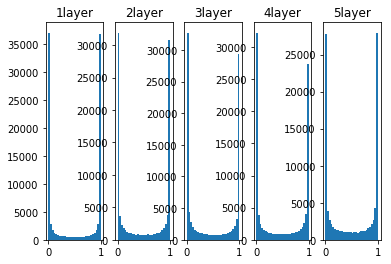

In [76]:
plot_hist(activations)

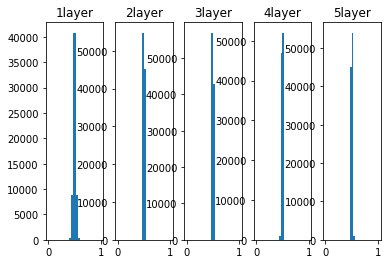

In [77]:
activations1 = experiment(sd=0.01)
plot_hist(activations1)

### 实验结论
- 根据上述的实验，可以看出，如果使用符合一般正态分布的随机值初始化权重，将引起权重分布机器不均匀，而最终导致“梯度消失”，图1，或者“表现力受限”，图2

### Xavier初始值 
- 当激活函数为Sigmoid、tanh等中间部分可看做线性的激活函数时，Xavier初始值为sqrt(1/n),其中n为前一层神经元个数

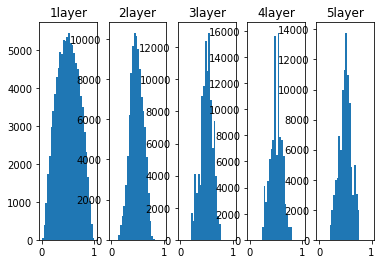

In [71]:
activations_xavier = experiment(sd = 0.1)
plot_hist(activations_xavier)

### He初始值 
- 当激活函数为ReLU函数时，He初始值为sqrt(2/n),其中n为前一层神经元个数

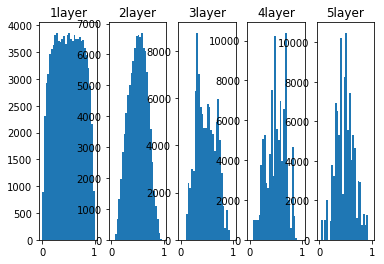

In [80]:
activations2 = experiment(sd=np.sqrt(0.02), activation_func='RelU')
plot_hist(activations2)

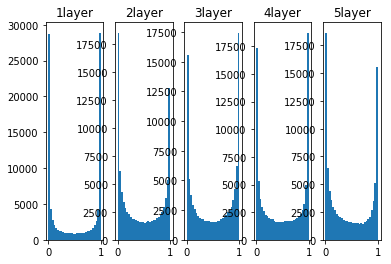

In [83]:
activations3 = experiment(sd=0.6, activation_func='RelU')
plot_hist(activations3)

### 实验结论
- Xavier、He初始值明显改善了权重的分布，更加“均匀”，尽量避免了“梯度消失”或者“表现力受限”的情况

### Batch Normalization （局部归一化）
- 加速学习过程
- 降低对初始权重值的依赖
- 抑制过拟合
- 调整各层激活值的分布，使其拥有适当广度，通过Batch Normalization层来实现

In [ ]:
def bn_forward(x, gamma, beta, eps):
    N, D = x.shape
    
    # 计算每一维度的平均值
    x_mean = np.mean(x, axis=0) # (D,)
    
    # 计算每一维度的方差
    diff = x - x_mean #(N, D)
    diff_square = np.square(diff)
    mean_diff_square = np.mean(diff_square, axis=0) #(D,)
    
    # 计算归一化之后的x
    sqrt_mean_diff_square = np.sqrt(mean_diff_square + eps)  # (D, )
    x_ = diff / sqrt_mean_diff_square # （N, D)
    
    # 输出
    y = gamma * x_ + beta # (N, D)
    
    return y,(x_mean, sigma_square, x_)

def bn_backward(dout, x_):
    dBeta = dout
    dGamma = dout * x_
    

In [264]:
class batch_normal(object):
    def __init__(self, gamma = 1, beta = 0, eps=10e-7):
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        
        self.dgamma = None
        self.dbeta = None
        
        self.mu = None
        self.xmu = None
        self.sq = None
        self.var = None
        self.sqrtvar = None
        self.ivar = None
        self.xhat = None
        self.gammax = None
        
    def forward(self, x):
        N, D = x.shape
    
        # 计算每一维度的平均值
        self.mu = np.mean(x, axis=0) # (D,)

        # 计算每一维度的方差
        self.xmu = x - self.mu #(N, D)
        self.sq = np.square(self.xmu)
        self.var = np.mean(self.sq, axis=0) #(D,)
        
        # 计算归一化之后的x
        self.sqrtvar = np.sqrt(self.var + self.eps)  # (D, )
        self.ivar = 1.0 / self.sqrtvar
        self.xhat = self.xmu * self.ivar # （N, D)
        self.gammax = self.gamma * self.xhat

        # 输出
        y = self.gammax + self.beta # (N, D)
        return y
    def backward(self, dout):
        self.dbeta = np.sum(dout, axis=0) #(D,)
        self.dgamma = np.sum(dout * self.xhat, axis=0) #(D,)
        
        # 计算dx,计算步骤比较长，需要一步一步进行计算，最后使用链式法则组装
        N, D = self.xhat.shape
        dy = dout * 1 #(N, D)
        dgammax = dy * 1
        dxhat = dgammax * self.gamma #(N, D)
        dxmu1 = dxhat * self.ivar # (N, D) 
        
        divar = np.sum(dxhat * self.xmu, axis=0) # (D,)
        dsqrtvar = divar * (-1.0 / np.square(self.sqrtvar)) #(D,)
        dvar = dsqrtvar * (1.0 / (2*self.sqrtvar))  #(D,)
        dsq = dvar * (np.ones((N, D)) * 1.0 / N) #(N, D)
        
        dxmu2 = dsq * 2 * self.xmu # (N, D) 
        
        dxmu = dxmu1 + dxmu2 # (N, D)
        dx1 = dxmu # (N, D) 
        
        dmu = np.sum(dxmu * (-1), axis=0) #(, D)
        
        dx2 = dmu * (np.ones((N, D))*1.0/N) #(N, D)
        
        dx = dx1 + dx2 #(N, D)
        return dx

In [162]:
x = np.random.randn(100, 50)

In [243]:
bn = batch_normal(1, 0)

In [244]:
y = bn.forward(x)

In [245]:
print y.shape

(100, 50)


In [246]:
dout = np.ones_like(x)

In [247]:
dx = bn.backward(dout)

In [248]:
print dx.shape

(100, 50)


In [319]:
def batchnorm_forward(x, gamma, beta, eps):

    N, D = x.shape

    #step1: calculate mean
    mu = 1./N * np.sum(x, axis = 0)

    #step2: subtract mean vector of every trainings example
    xmu = x - mu

    #step3: following the lower branch - calculation denominator
    sq = xmu ** 2

    #step4: calculate variance
    var = 1./N * np.sum(sq, axis = 0)

    #step5: add eps for numerical stability, then sqrt
    sqrtvar = np.sqrt(var + eps)

    #step6: invert sqrtwar
    ivar = 1./sqrtvar

    #step7: execute normalization
    xhat = xmu * ivar

    #step8: Nor the two transformation steps
    gammax = gamma * xhat

    #step9
    out = gammax + beta

    #store intermediate
    cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)

    return out, cache

def batchnorm_backward(dout, cache):

    #unfold the variables stored in cache
    xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache

    #get the dimensions of the input/output
    N,D = dout.shape

    #step9
    dbeta = np.sum(dout, axis=0)
    dgammax = dout #not necessary, but more understandable

    #step8
    dgamma = np.sum(dgammax*xhat, axis=0)
    dxhat = dgammax * gamma

    #step7
    divar = np.sum(dxhat*xmu, axis=0)
    dxmu1 = dxhat * ivar

    #step6
    dsqrtvar = -1. /(sqrtvar**2) * divar

    #step5
    dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

    #step4
    dsq = 1. /N * np.ones((N,D)) * dvar

    #step3
    dxmu2 = 2 * xmu * dsq

    #step2
    dx1 = (dxmu1 + dxmu2)
    dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

    #step1
    dx2 = 1. /N * np.ones((N,D)) * dmu

    #step0
    dx = dx1 + dx2

    return dx, dgamma, dbeta

In [249]:
y1, cache = batchnorm_forward(x, 1, 0, 10e-7)

In [250]:
ddx, dgamma, dbeta = batchnorm_backward(dout, cache)

In [317]:
bn.dgamma == dgamma

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True], dtype=bool)

In [318]:
dbeta == bn.dbeta

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [257]:
dx[0] == ddx[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

### 正则化
- 为了抑制过拟合，给损失函数添加正的正则化项来使权重减小的方法，包括L1、L2两种方法，L2正则化可使权重全部减小，L1正则化则能稀疏化权重，使产生更多的权重值为0
- 权重衰减项即是每层 **W** 的线性加和，在最终的反向传播的过程中，只需要在 **dW** 项中加上 **lambda x W**即可

### Dropout层
- 为了抑制过拟合，DropOut层在每层随机选择部分神经元使之失活，输出为0，达到降低模型复杂度，从而减小过拟合现象

In [322]:
class Dropout(object):
    def __init__(self, dropout_radio = 0.4):
        self.dropout_radio = dropout_radio
        self.mask = None
    def forward(self, x, train_sign=True):
        if train_sign == True:
            self.mask = np.random.rand(*x.shape) > self.dropout_radio
            return self.mask * x
        else:
            return x * (1 - self.dropout_radio)  # 为啥要这样处理？
    def backward(self, dout):
        return dout * self.mask